<a href="https://colab.research.google.com/github/EziamaUgonna/Bayesian_analysis-/blob/master/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install packages
#!pip install -q --upgrade tf-nightly-gpu-2.0-preview
#!pip install -q tfp-nightly
#!pip uninstall tensorflow
!pip install tensorflow==2.0.0-beta1
#!pip install tensorflow-addons

     |████████████████████████████████| 87.9MB 93kB/s 
     |████████████████████████████████| 501kB 44.8MB/s 
     |████████████████████████████████| 3.1MB 44.3MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import vaex
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
#from tensorflow_probability.python.math import random_rademacher
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import ReLU, Dropout
from tensorflow.keras.optimizers import Adam
# Settings
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
sns.set()
%config InlineBackend.figure_format = 'svg'
np.random.seed(12345)
tf.random.set_seed(1234)
tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'2.0.0-beta1'

In [0]:
from google.colab import drive
drive.mount("/content/gdrive")

In [0]:
!ls "/content/gdrive/My Drive/"

 BNN_Work.ipynb   BSM5.csv		 Sensor1_values_bias_0_1_dur_10_dep.csv
 BSM10.csv	  BSM6.csv		 Ugonna.ipynb
 Bsm.11.csv	  BSM7.csv		 Untitled0.ipynb
 Bsm.12.csv	  BSM8.csv		 Untitled1.ipynb
 Bsm.13.csv	  BSM9.csv		 Variational_autoencoder-1-1.ipynb
 Bsm.14.csv	  BSM_man1.csv		 work1.csv
 Bsm.15.csv	 'Colab Notebooks'	 work2.csv
 BSM1.csv	  Data.csv.csv		'work _desertation.ipynb'
 BSM2.csv	  Dissertation_data	 work_main
 BSM3.csv	 'Getting started.pdf'
 BSM4.csv	 'New folder (2).zip'


In [0]:
# Read in the dataset
df = pd.read_csv('/content/gdrive/My Drive/Sensor1_values_bias_0_1_dur_10_dep.csv').astype(np.float32)
df =  np.array(df)

df.shape

(29800, 4)

In [0]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [0]:
original_dim = 4
intermediate_dim = 64
latent_dim = 32

class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=32,
               intermediate_dim=64,
               name='encoder',
               **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_mean = layers.Dense(latent_dim)
    self.dense_log_var = layers.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.dense_proj(inputs)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,
               name='decoder',
               **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_output = layers.Dense(original_dim, activation='sigmoid')

  def call(self, inputs):
    x = self.dense_proj(inputs)
    return self.dense_output(x)


class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,original_dim,intermediate_dim=64,latent_dim=32,name='autoencoder', **kwargs):
    super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
    self.original_dim = original_dim
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstructed = self.decoder(z)
    # Add KL divergence regularization loss.
    kl_loss = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    self.add_loss(kl_loss)
    return reconstructed


vae = VariationalAutoEncoder(original_dim, 64, 32)


In [0]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=200)
#X_train, X_valid = train_test_split(X_train_full, test_size=0.2, random_state=1)


In [0]:
# Standardize the dataset 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
#X_valid_scaled = scaler.transform(X_valid.astype(np.float32))
X_test_scaled = scaler.transform( X_test.astype(np.float32))

In [0]:
#X_train_scaled = tf.data.Dataset.from_tensor_slices(X_train_scaled).shuffle(1000).repeat(3).batch(7)
#X_test_scaled = tf.data.Dataset.from_tensor_slices(X_test_scaled).shuffle(1000).repeat(3).batch(7)


In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss = 'mean_squared_error')
checkpointer1 = ModelCheckpoint(filepath = 'model.weights.best.hdf5', verbose = 2, save_best_only = True)
checkpointer2 = EarlyStopping(monitor ='val_loss', min_delta = 0.0005, patience = 2, verbose =2, mode = 'auto')

In [0]:
vae.fit(X_train_scaled, X_train_scaled, batch_size= 64, epochs =1000, callbacks = [checkpointer2], validation_split = 0.1 )

Train on 21456 samples, validate on 2384 samples
Epoch 1/1000
21456/21456 [==============================] - 1s 48us/sample - loss: 0.7162 - val_loss: 0.7010
Epoch 2/1000
21456/21456 [==============================] - 1s 34us/sample - loss: 0.7168 - val_loss: 0.7024
Epoch 3/1000
21456/21456 [==============================] - 1s 34us/sample - loss: 0.7173 - val_loss: 0.7031
Epoch 00003: early stopping


In [0]:
vae.load_weights("./model.weights.best.hdf5")

vae.predict(X_test_scaled)

array([[2.2557124e-01, 7.0238113e-04, 4.8047304e-04, 1.4603138e-06],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [5.4836273e-06, 0.0000000e+00, 0.0000000e+00, 9.7870606e-01],
       ...,
       [3.8165748e-02, 1.7881393e-07, 1.1920929e-07, 1.1146069e-03],
       [6.2584877e-07, 4.5575541e-01, 4.2489153e-01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.4901161e-06]],
      dtype=float32)

ValueError: ignored

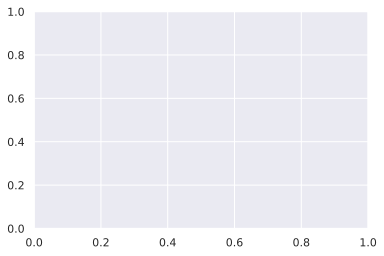

In [0]:
loss = vae.history.history['loss']
val_loss = vae.history.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()